# Youtube comments spam classification

This dataset is comprise of comments collection from users for videos on youtube of artist i.e Psy, Katy Perry, LMFAO, Eminem, and Shakira.

In these datasets, there is a class column where (0) indicates that it is not a spam and (1) if it is a Spam.

We will use this to build models which classify the comment is either a spam or not.


In [24]:
#pip install emoji

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from collections import Counter
import nltk
import html
import re
import string
import emoji

In [26]:
nltk.download('punkt')

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1108)>


False

## Importing dataset
First off we will be importing the datasets using the pandas library. the dataset from each csv file is merged into a variable called frames. ignore_index which is False in default is set to True so the resulting index will be written 0,1..n-1

In [27]:
df1 = pd.read_csv('Youtube01-Psy.csv')
df2 = pd.read_csv('Youtube02-KatyPerry.csv')
df3 = pd.read_csv('Youtube03-LMFAO.csv')
df4 = pd.read_csv('Youtube04-Eminem.csv')
df5 = pd.read_csv('Youtube05-Shakira.csv')

frames = [df1,df2,df3,df4,df5]
df = pd.concat(frames, ignore_index=True)
df.to_csv("not_clean.csv")

Here we can see what the columns of the datasets comprise of :

In [28]:
print(df.shape)
print(df.columns)
df.head

(1956, 5)
Index(['COMMENT_ID', 'AUTHOR', 'DATE', 'CONTENT', 'CLASS'], dtype='object')


<bound method NDFrame.head of                                        COMMENT_ID                AUTHOR  \
0     LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU             Julius NM   
1     LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A           adam riyati   
2     LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8      Evgeny Murashkin   
3             z13jhp0bxqncu512g22wvzkasxmvvzjaz04       ElNino Melendez   
4             z13fwbwp1oujthgqj04chlngpvzmtt3r3dw                GsMega   
...                                           ...                   ...   
1951  _2viQ_Qnc6-bMSjqyL1NKj57ROicCSJV5SwTrw-RFFA          Katie Mettam   
1952  _2viQ_Qnc6-pY-1yR6K2FhmC5i48-WuNx5CumlHLDAI  Sabina Pearson-Smith   
1953  _2viQ_Qnc6_k_n_Bse9zVhJP8tJReZpo8uM2uZfnzDs         jeffrey jules   
1954  _2viQ_Qnc6_yBt8UGMWyg3vh0PulTqcqyQtdE7d4Fl0        Aishlin Maciel   
1955  _2viQ_Qnc685RPw1aSa1tfrIuHXRvAQ2rPT9R06KTqA           Latin Bosch   

                            DATE  \
0            2013-11-07T06:20:48 

## Exploratory data analysis.
Distribution by label: Spam count is slightly more than spam altho not significant.

Text(0.5, 1.0, 'Frequency of Ham(0) & Spam(1)')

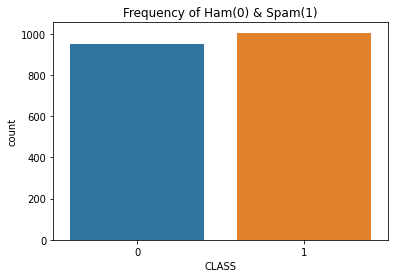

In [29]:
sb.countplot(x='CLASS',data=df).set_title("Frequency of Ham(0) & Spam(1)")

Now we can explore the average length of a spam or a ham. I start by counting the length ("comment_len") to know the length of comment appeared in each "CLASS" respectively

In [30]:
df['comment_len'] = df['CONTENT'].apply(len)
df.head(5)

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS,comment_len
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1,56
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1,166
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1,38
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,48
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1,39


In [31]:
df.groupby('CLASS').describe()

comment_len                                                         
            count        mean         std   min   25%   50%    75%     max
CLASS                                                                     
0           951.0   49.644585   56.284782   2.0  18.0  34.0   62.0   753.0
1          1005.0  137.336318  158.977404  10.0  36.0  65.0  171.0  1200.0

Let's visualize distribution pattern of comment length by plotting a boxplot and normalized histgram. We can see that Spam messages are in general consists of more words compared to ham which makes sense because a comment unrelated to the video might been a comment which is trying to lure viewers into their site as compared to the normal comments in a youtube video.

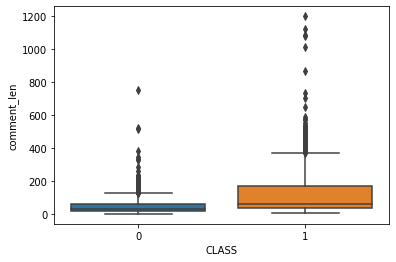

In [32]:
sb.boxplot(x='CLASS', y='comment_len', data=df)

In [33]:
#Trying to insert all available words in a list individually and count the most occuring word in each list.

spam_comments = df[df["CLASS"] == 1]["CONTENT"]
ham_comments = df[df["CLASS"] == 0]["CONTENT"]

spam_words = []
ham_words = []

def spamword (spamWords) :
    global spam_words
    words = [word.lower() for word in spam_comments if word.lower().isalpha()]
    spam_words = spam_words + words
    
def hamword (spamWords) :
    global ham_words
    words = [word.lower() for word in ham_comments if word.lower().isalpha()]
    ham_words = ham_words + words

spamlist = spamword(spam_comments)
hamlist = hamword(spam_comments)

count_ham  = Counter(hamlist)
count_spam = Counter(spamlist)

#Using Counter mos_common method to count most common instance in a dataFrame
df_ham  = pd.DataFrame(count_ham.most_common(20),  columns=['word', 'count'])
df_spam = pd.DataFrame(count_spam.most_common(20), columns=['word', 'count'])



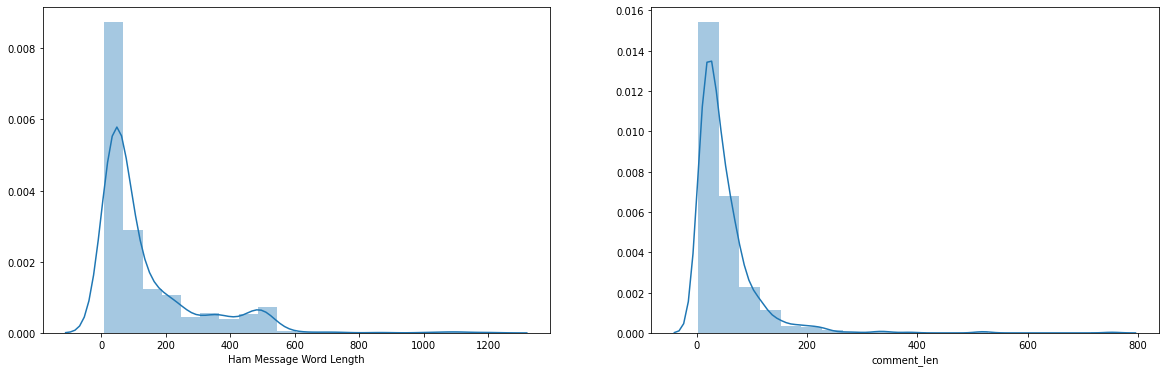

In [34]:
f, ax = plt.subplots(1, 2, figsize = (20, 6))

sb.distplot(df[df["CLASS"] == 1]["comment_len"], bins = 20, ax = ax[0])
ax[0].set_xlabel("Spam Messages Word Length")

sb.distplot(df[df["CLASS"] == 0]["comment_len"], bins = 20, ax = ax[1])
ax[0].set_xlabel("Ham Message Word Length")

plt.show()

In [35]:
df.comment_len.describe()

count    1956.000000
mean       94.700920
std       128.222062
min         2.000000
25%        29.000000
50%        48.000000
75%        97.000000
max      1200.000000
Name: comment_len, dtype: float64

In [36]:
# Let's see the longest message 1200
df[df['comment_len'] == 1200]['CONTENT'].iloc[0]

'&lt;script&gt;document.write(\'&lt;a target="_self" href=" http://rover.ebay.com/rover/1/710-53481-19255-0/1?icep_ff3=1&amp;pub=5575096797&amp;toolid=10001&amp;campid=5337555197&amp;customid=bogdan+grigore&amp;ipn=psmain&amp;icep_vectorid=229508&amp;kwid=902099&amp;mtid=824&amp;kw=lg"&gt;check  this out new arive on ebay&lt;/a&gt;&lt;img  style="text-decoration:none;border:0;padding:0;margin:0;" src=" http://rover.ebay.com/roverimp/1/710-53481-19255-0/1?ff3=1&amp;pub=5575096797&amp;toolid=10001&amp;campid=5337555197&amp;customid=bogdan+grigore&amp;mpt=\'+Math.floor(Math.random()*999999999)+\'"&gt;\');&lt;/script&gt;&lt;noscript&gt;&lt;a  target="_self" href=" http://rover.ebay.com/rover/1/710-53481-19255-0/1?icep_ff3=1&amp;pub=5575096797&amp;toolid=10001&amp;campid=5337555197&amp;customid=bogdan+grigore&amp;ipn=psmain&amp;icep_vectorid=229508&amp;kwid=902099&amp;mtid=824&amp;kw=lg"&gt;check  this out new arive on ebay&lt;/a&gt;&lt;img  style="text-decoration:none;border:0;padding:0;ma

We only need data from Comment and Class column. So, we will drop the other columns that is not important in this project.

In [37]:
df = df.drop(['COMMENT_ID', 'AUTHOR', 'DATE', 'comment_len'], axis=1)

In [38]:
print(df.describe)

<bound method NDFrame.describe of                                                 CONTENT  CLASS
0     Huh, anyway check out this you[tube] channel: ...      1
1     Hey guys check out my new channel and our firs...      1
2                just for test I have to say murdev.com      1
3      me shaking my sexy ass on my channel enjoy ^_^ ﻿      1
4               watch?v=vtaRGgvGtWQ   Check this out .﻿      1
...                                                 ...    ...
1951  I love this song because we sing it at Camp al...      0
1952  I love this song for two reasons: 1.it is abou...      0
1953                                                wow      0
1954                            Shakira u are so wiredo      0
1955                         Shakira is the best dancer      0

[1956 rows x 2 columns]>


Lowercase all the words in the df column "CONTENT"

In [39]:
df["CONTENT"] = df["CONTENT"].str.lower()

Replace all the html tags <a... > with the keyword "htmllink"

In [40]:
df['CONTENT']=df['CONTENT'].str.replace("(<a.+>)","htmllink")

Remove all other html tags.

In [41]:
df['CONTENT']=df['CONTENT'].str.replace("(<.+>)","")

Replace all the strings starting with "http" or "https" with the keyword "htmllink"

In [42]:
df['CONTENT']=df['CONTENT'].str.replace(r'(https?://\S+|http?://\S+ )',"htmllink")

Replace all the strings containing ".com"  or "watch\"  with the keyword "htmllink"

In [43]:
df["CONTENT"]=df["CONTENT"].str.replace(r"\S*.com\S*|\S*watch\?\S*","htmllink")

In [44]:
def clean_nonalpha(input_text):
  pattern = re.compile('([^\s\w]|)+')
  return pattern.sub("",input_text)

In [45]:
def translate_emojis(input_text):
  return emoji.demojize(input_text, delimiters=(" ", " "))

In [46]:
def clean_only_numbers(input_text):
  return ' '.join(word for word in input_text.split() if not word.isdigit())

In [47]:
df["CONTENT"]=df["CONTENT"].apply(translate_emojis)

In [48]:
df["CONTENT"]=df["CONTENT"].apply(clean_nonalpha)

In [49]:
df["CONTENT"]=df["CONTENT"].apply(clean_only_numbers)

According to the paper, they achieved better results by not filtering stopwords and lemmatizing. This first approach is not going to perform further filtering.

Bag of words approach.

In [50]:
vocab = []
for sentence in df["CONTENT"]:
  for word in sentence.split():
    vocab.append(word)

In [51]:
# Eliminate duplicate words in the vocabulary
vocabulary = set(vocab)
print(len(vocabulary))

3849


In [52]:
for word in vocabulary:
  df[word] = 0

In [53]:
df.head()

,CONTENT,CLASS,dopethat39s,worried,legit,title,shaki,rich,conveying,firms,...,online,hopefully,pussy,trusted,expecting,wholehearted,mini,zero,megan,better
0,huh anyway check out this youtube channel koby...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,hey guys check out my new channel and our firs...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,just for test i have to say htmllink,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,me shaking my sexy ass on my channel enjoy _,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,htmllink check this out,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
for index, sentence in enumerate(df["CONTENT"]):
  for word in sentence.split():
    df[word].iloc[index] += 1  


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [55]:
df.head()

,CONTENT,CLASS,dopethat39s,worried,legit,title,shaki,rich,conveying,firms,...,online,hopefully,pussy,trusted,expecting,wholehearted,mini,zero,megan,better
0,huh anyway check out this youtube channel koby...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,hey guys check out my new channel and our firs...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,just for test i have to say htmllink,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,me shaking my sexy ass on my channel enjoy _,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,htmllink check this out,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we can create two dictionaries, for spam and not spam comments, containing the words and the total count

In [56]:
df_spam =df[df["CLASS"] == 1]
df_spam.loc['Total']= df_spam.sum(numeric_only=True, axis=0)
df_spam.tail()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,CONTENT,CLASS,dopethat39s,worried,legit,title,shaki,rich,conveying,firms,...,online,hopefully,pussy,trusted,expecting,wholehearted,mini,zero,megan,better
1944,hey music fans i really appreciate all of you ...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1945,check out my new mixtape check out my new mixt...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1946,check out my new mixtape check out my new mixt...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1947,check out my new mixtape check out my new mixt...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Total,NaN,1005.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,...,34.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,11.0


In [57]:
print(df_spam.shape)

(1006, 3851)


In [58]:
df_not_spam =df[df["CLASS"] == 0]
df_not_spam.loc['Total']= df_not_spam.sum(numeric_only=True, axis=0)
df_not_spam.tail()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,CONTENT,CLASS,dopethat39s,worried,legit,title,shaki,rich,conveying,firms,...,online,hopefully,pussy,trusted,expecting,wholehearted,mini,zero,megan,better
1952,i love this song for two reasons 1it is about ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1953,wow,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1954,shakira u are so wiredo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1955,shakira is the best dancer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Total,NaN,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,14.0,7.0


In [59]:
print(df_not_spam.shape)

(952, 3851)


Drop the first two columns of each dictionary.

In [60]:
df_spam.drop("CONTENT",1,inplace=True)
df_spam.drop("CLASS",1,inplace=True)
df_not_spam.drop("CONTENT",1,inplace=True)
df_not_spam.drop("CLASS",1,inplace=True)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [61]:
dict_spam = {word: count for word, count in zip(df_spam.columns,df_spam.loc['Total'])}
dict_not_spam = {word: count for word, count in zip(df_not_spam.columns,df_not_spam.loc['Total'])}

In [62]:
sorted_spam = sorted(dict_spam.items(),key=lambda x: x[1], reverse=True)
sorted_not_spam = sorted(dict_not_spam.items(),key=lambda x: x[1], reverse=True)
print(sorted_spam[:10])
print(sorted_not_spam[:10])

[('out', 569.0), ('check', 545.0), ('htmllink', 514.0), ('my', 512.0), ('and', 485.0), ('to', 480.0), ('you', 463.0), ('i', 457.0), ('the', 413.0), ('a', 389.0)]
[('this', 293.0), ('i', 284.0), ('the', 278.0), ('song', 217.0), ('is', 214.0), ('love', 144.0), ('to', 133.0), ('and', 132.0), ('a', 114.0), ('it', 112.0)]


In [63]:
X = df.iloc[:,2:]
y = df.iloc[:,1]
pd.crosstab(index=y,columns="Count")

col_0,Count
CLASS,
0,951
1,1005


## Data Model
For classification there are some famous classification algorithms and we are going to use the below classification algorithms with this data set and see their prediction results The Algorithms used below in this notebooks are :

- Multinomial Naive Bayes
- K-Nearest Neighbour
- Support Vector Machine 
- Gaussian Naive Bayes

In [64]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [65]:
from sklearn.svm import SVC #support vector classifier
clf = SVC(kernel='linear', random_state=0, gamma=0.001).fit(X_train, y_train)
print(clf)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)


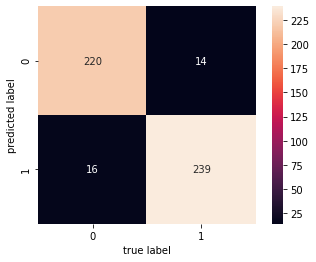

In [66]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
y_pred = clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred) #Print the number of good/bad classified points 
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [67]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.93      0.94       236
           1       0.94      0.94      0.94       253

    accuracy                           0.94       489
   macro avg       0.94      0.94      0.94       489
weighted avg       0.94      0.94      0.94       489



Implementing Naive Bayes model on the train dataset classified with bag2words approach

We will use sklearns sklearn.naive_bayes method to make predictions on our dataset.

Specifically, we will be using the multinomial Naive Bayes. This particular classifier is suitable for classification with discrete features (such as in our case, word counts for text classification). It takes in integer word counts as its input.

the alpha parameter in MultinomialNB is set to 0.75 because the accuracy score is the best at this number as compared to the default value 1.0

In [94]:
# import and initialize a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB(alpha=0.75)

In [95]:
#Train model
nb.fit(X_train, y_train)

MultinomialNB(alpha=0.75, class_prior=None, fit_prior=True)

In [96]:
#Predict the outcome of either spam or ham
y_pred_NB = nb.predict(X_test)

In [97]:
# calculate accuracy of class predictions
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_NB)

0.9141104294478528

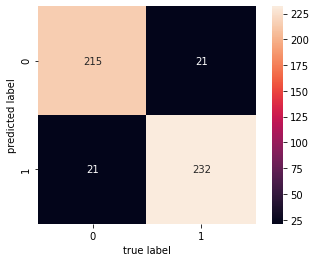

In [101]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
mat = confusion_matrix(y_test, y_pred_NB) #Print the number of good/bad classified points 
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [102]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_NB, digits=4))

              precision    recall  f1-score   support

           0     0.9110    0.9110    0.9110       236
           1     0.9170    0.9170    0.9170       253

    accuracy                         0.9141       489
   macro avg     0.9140    0.9140    0.9140       489
weighted avg     0.9141    0.9141    0.9141       489



Implementing KNN model on the train dataset classified with bag2words approach

Feature Scaling

In [103]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaler = scaler.transform(X_train)
X_test_scaler = scaler.transform(X_test)

Training and Predictions

In [104]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(X_train_scaler, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [105]:
y_pred_knn = classifier.predict(X_test_scaler)

Evaluating the Algorithm

In [106]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

[[223  13]
 [ 60 193]]
              precision    recall  f1-score   support

           0       0.79      0.94      0.86       236
           1       0.94      0.76      0.84       253

    accuracy                           0.85       489
   macro avg       0.86      0.85      0.85       489
weighted avg       0.87      0.85      0.85       489



Comparing Error Rate with the K Value

In [107]:
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

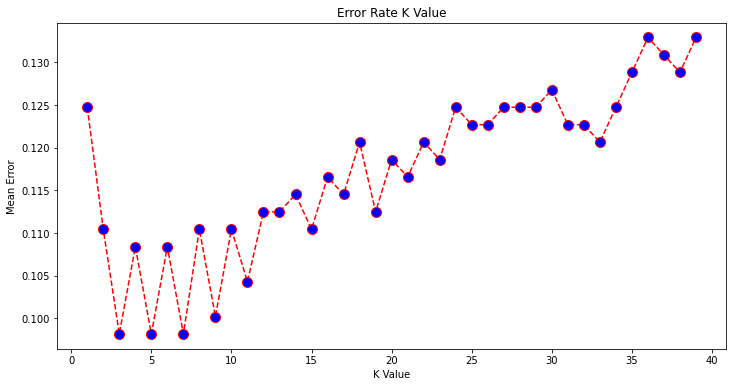

In [108]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

 The mean error is low when the value of the K is 5 and 9

Implementing Gaussian model on the train dataset classified with bag2words approach

Here we will be using Gaussian Naive Bayes (GNB) classification on the word counts. Compared to multinomial naive bayes classification, it is likely that we will find the accuracy for spam classification worse as GNB is better suited for continuous data as it assumes that the input data has a Gaussian(normal) distribution.

In [109]:
from sklearn.naive_bayes import GaussianNB
#initialize 
gb = GaussianNB()
print(gb)

#train model
gb.fit(X_train, y_train)

#Predict the outcome of either spam or ham
y_pred_gb = gb.predict(X_test)

# calculate accuracy of class predictions
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_gb)

GaussianNB(priors=None, var_smoothing=1e-09)


0.7689161554192229

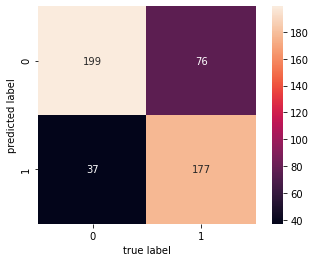

In [110]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
mat = confusion_matrix(y_test, y_pred_gb) #Print the number of good/bad classified points 
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [111]:
print(classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

           0       0.72      0.84      0.78       236
           1       0.83      0.70      0.76       253

    accuracy                           0.77       489
   macro avg       0.78      0.77      0.77       489
weighted avg       0.78      0.77      0.77       489



Implementing simple svm linear model on the train dataset classified with bag2words approach

In [112]:
sig = SVC(kernel='sigmoid', random_state=0, gamma=0.001).fit(X_train, y_train)
print(sig)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='sigmoid',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)


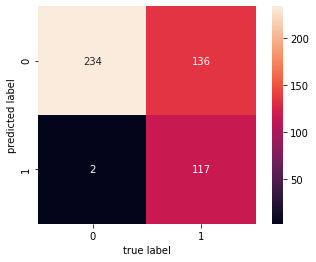

In [113]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
y_pred_sig = sig.predict(X_test)
mat = confusion_matrix(y_test, y_pred_sig) #Print the number of good/bad classified points 
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [114]:
print(classification_report(y_test, y_pred_sig))

              precision    recall  f1-score   support

           0       0.63      0.99      0.77       236
           1       0.98      0.46      0.63       253

    accuracy                           0.72       489
   macro avg       0.81      0.73      0.70       489
weighted avg       0.81      0.72      0.70       489



### Compare accuracy score to the other classifier

In [117]:
from sklearn.metrics import accuracy_score
print('Accuracy score for linear kernel: {}'.format(accuracy_score(y_test, y_pred)))
print('Accuracy score for multinomial naive bayes: {}'.format(accuracy_score(y_test, y_pred_NB)))
print('Accuracy score for KNN: {}'.format(accuracy_score(y_test, y_pred_knn)))
print('Accuracy score for gaussian naive bayes: {}'.format(accuracy_score(y_test, y_pred_gb)))
print('Accuracy score for sigmoid kernel: {}'.format(accuracy_score(y_test, y_pred_sig )))

Accuracy score for linear kernel: 0.8507157464212679
Accuracy score for multinomial naive bayes: 0.9141104294478528
Accuracy score for KNN: 0.8507157464212679
Accuracy score for gaussian naive bayes: 0.7689161554192229
Accuracy score for sigmoid kernel: 0.7177914110429447


We can see the Naive Bayes have the best score over other classification algorithms. Its ability to handle an extremely large number of features which is in our case, each word is treated as a feature and there are thousands of different words. Also, it performs well even with the presence of irrelevant features and is relatively unaffected by them as we can see by removing emojis from the comments. Also tuning the parameters for Naive Bayes' are not really necessary except when distribution of data is well known.

# **Word2Vec Model**

In [118]:
#pip install --upgrade gensim

In [119]:
import spacy
import multiprocessing
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
import sys

In [120]:
df.to_csv("clean_comments.csv")
!python -m spacy download en

Traceback (most recent call last):
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 163, in _run_module_as_main
    mod_name, _Error)
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/runpy.py", line 111, in _get_module_details
    __import__(mod_name)  # Do not catch exceptions initializing package
  File "/Users/toedark/Library/Python/2.7/lib/python/site-packages/spacy/__init__.py", line 12, in <module>
    from . import pipeline
  File "/Users/toedark/Library/Python/2.7/lib/python/site-packages/spacy/pipeline/__init__.py", line 4, in <module>
    from .pipes import Tagger, DependencyParser, EntityRecognizer, EntityLinker
  File "pipes.pyx", line 25, in init spacy.pipeline.pipes
  File "/Users/toedark/Library/Python/2.7/lib/python/site-packages/spacy/pipeline/functions.py", line 4, in <module>
    from ..language import component
  File "/Users/toedark/Library/Python/2.7/lib/python/site-packages/spacy/language

In [121]:
class W2V_embedding:
  def __init__(self, document, lemma, stopwords, min_count, window, nlp):
    self.document = document
    self.nlp = nlp
    self.lemma = lemma
    self.stopwords = stopwords
    self.min_count = min_count
    self.window = window
  def clean_sentence(self, sentence):
    # Lemmatizes and removes stopwords
    if self.lemma and self.stopwords:
      txt = [token.lemma_ for token in sentence if not token.is_stop]
    elif self.lemma:
      txt = [token.lemma_ for token in sentence ]
    elif self.stopwords:
      txt = [token for token in sentence if not token.is_stop]
    return ' '.join(txt)
  def clean_document(self):
    #Clean and drop duplicates from the comments in the dataset.
    txt = [self.clean_sentence(sentence) for sentence in self.nlp.pipe(self.document, batch_size=500, n_threads=-1)]
    df_clean = pd.DataFrame({'clean': txt})
    df_clean = df_clean.dropna().drop_duplicates()
    sentences = [row.split() for row in df_clean['clean']]
    return sentences
  def run(self):
    self.sentences = self.clean_document()
    cores = multiprocessing.cpu_count() 
    w2v_model = Word2Vec(min_count=self.min_count,
                     window=self.window,
                     size=300,
                     workers=cores-1)
    w2v_model.build_vocab(self.sentences, progress_per=100)
    w2v_model.train(self.sentences, total_examples=w2v_model.corpus_count, epochs=50, report_delay=1)
    w2v_model.init_sims(replace=True)
    return w2v_model


In [122]:
nlp = spacy.load('en', disable=['ner','parser'])
init_w2v = W2V_embedding(min_count=1, window=5, lemma=True, stopwords=True, document=df["CONTENT"], nlp=nlp)
w2v_model = init_w2v.run()

In [123]:
w2v_model.wv.most_similar(positive=["like"])

[('second', 0.9790601134300232),
 ('kitten', 0.9631423950195312),
 ('let', 0.9568048715591431),
 ('you39re', 0.9518523812294006),
 ('think', 0.9510156512260437),
 ('d', 0.9504570960998535),
 ('miss', 0.9434739351272583),
 ('people', 0.941035807132721),
 ('loose', 0.939953088760376),
 ('life', 0.939685583114624)]

In [124]:
comments_array = np.zeros(shape=(len(df["CONTENT"]),300))
for index, sentence in enumerate(df["CONTENT"]):
  tokens = nlp(sentence)
  clean_sentence = [token.lemma_ for token in tokens if not token.is_stop]
  #clean_sentence = [str(token) for token in tokens ]
  sentence_vector = []
  for word in clean_sentence: # In the case a word is not found in the vocabulary, we will append a vector of zeros instead
    try: 
      sentence_vector.append(w2v_model[word] ) 
    except:
      sentence_vector.append(np.zeros(300))
      print(word, 'not found')
  comments_array[index] = np.mean(sentence_vector,axis=0)

<ipython-input-124-09fbaba9c113>:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  sentence_vector.append(w2v_model[word] )
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [125]:
X = comments_array
isnan = np.argwhere(np.isnan(X))
nan_comments = sorted(set(isnan[:,0])) #index of comments that are NaN values

In [126]:
X[nan_comments,:] = np.zeros(300) # translating NaN comments to an array of zeroes
y = df.iloc[:,1]

In [127]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
clf = SVC(kernel='linear', random_state=0, gamma=0.001).fit(X_train, y_train)
print(clf)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='linear',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)


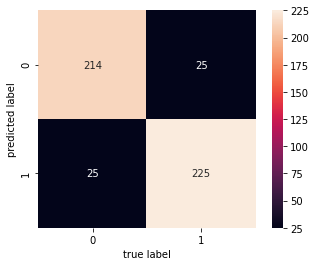

In [128]:
y_pred = clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred) #Print the number of good/bad classified points 
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [129]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90       239
           1       0.90      0.90      0.90       250

    accuracy                           0.90       489
   macro avg       0.90      0.90      0.90       489
weighted avg       0.90      0.90      0.90       489



Implementing Naive Bayes model on the train dataset classified with Word2vec approach

In [130]:
# import and initialize a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb2 = MultinomialNB(alpha=0.75)

#checking the range of the numpy array 
r = np.ptp(X_train,axis=1)
print(X_train)
print(r)
print("range of numpy array :", max(r), min(r))

[[-3.11910175e-03  7.51368925e-02  1.91159993e-02 ... -2.49129888e-02
  -3.15935649e-02 -3.45714726e-02]
 [ 1.94622949e-02  7.68072605e-02  1.41833052e-02 ... -9.14071202e-02
   7.79983215e-03 -1.96736283e-03]
 [ 1.23785054e-02  4.44498844e-02 -2.64304951e-02 ... -5.03486991e-02
  -1.14529552e-02 -3.11698169e-02]
 ...
 [ 2.21716743e-02  4.19173874e-02 -1.15951309e-02 ... -7.38404021e-02
  -5.81055507e-03  4.86060902e-02]
 [ 2.35907044e-02  7.72530958e-02  9.24529787e-03 ... -9.95092317e-02
   9.61658731e-03 -2.24172585e-02]
 [ 1.51786301e-02  6.05290197e-02  1.40940612e-02 ... -6.99154660e-02
   6.61352096e-05 -8.47306103e-04]]
[0.30074081 0.26718538 0.32429318 ... 0.31678379 0.29476407 0.27461383]
range of numpy array : 0.3903636336326599 0.0


In [131]:
from sklearn.preprocessing import MinMaxScaler
#Normalizing the values in the array because naive bayes doesn't work with negative values
scaler = MinMaxScaler()
X_train_minmax = scaler.fit_transform(X_train)

In [132]:
#Train model
nb2.fit(X_train_minmax, y_train)

MultinomialNB(alpha=0.75, class_prior=None, fit_prior=True)

In [133]:
#Predict the outcome of either spam or ham
y_pred_NB2 = nb2.predict(X_test)

In [134]:
# calculate accuracy of class predictions
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_NB2)

0.8404907975460123

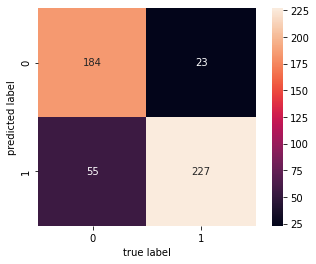

In [149]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
mat = confusion_matrix(y_test, y_pred_NB2) #Print the number of good/bad classified points 
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [163]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_NB2, digits=4))

              precision    recall  f1-score   support

           0     0.8889    0.7699    0.8251       239
           1     0.8050    0.9080    0.8534       250

    accuracy                         0.8405       489
   macro avg     0.8469    0.8389    0.8392       489
weighted avg     0.8460    0.8405    0.8396       489



K-nearest Neighbor

Feature Scaling

In [164]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaler = scaler.transform(X_train)
X_test_scaler = scaler.transform(X_test)

Training and Predictions

In [165]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=4)
classifier.fit(X_train_scaler, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

In [166]:
y_pred_knn2 = classifier.predict(X_test_scaler)

In [167]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred_knn2))
print(classification_report(y_test, y_pred_knn2))

[[219  20]
 [ 33 217]]
              precision    recall  f1-score   support

           0       0.87      0.92      0.89       239
           1       0.92      0.87      0.89       250

    accuracy                           0.89       489
   macro avg       0.89      0.89      0.89       489
weighted avg       0.89      0.89      0.89       489



Comparing Error Rate with the K Value

In [168]:
error = []

# Calculating error for K values between 1 and 40
for i in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_scaler, y_train)
    pred_i = knn.predict(X_test)
    error.append(np.mean(pred_i != y_test))

Text(0, 0.5, 'Mean Error')

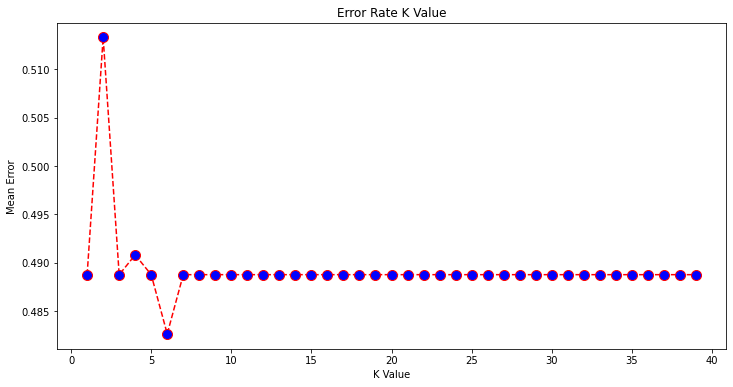

In [170]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 40), error, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean Error')

Best K value is probably between 3 and 5 as can be seen from the error rate k value

Implementing Gaussian model on the train dataset classified with word2vec approach

In [171]:
from sklearn.naive_bayes import GaussianNB
#initialize 
gb = GaussianNB()

#train model
gb.fit(X_train, y_train)

#Predict the outcome of either spam or ham
y_pred_gb2 = gb.predict(X_test)

# calculate accuracy of class predictions
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_gb2)

0.8588957055214724

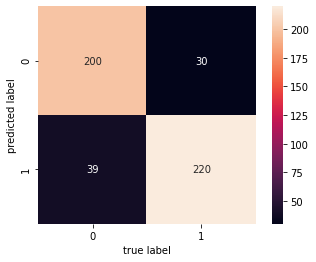

In [172]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
mat = confusion_matrix(y_test, y_pred_gb2) #Print the number of good/bad classified points 
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [174]:
print(classification_report(y_test, y_pred_gb2))

              precision    recall  f1-score   support

           0       0.87      0.84      0.85       239
           1       0.85      0.88      0.86       250

    accuracy                           0.86       489
   macro avg       0.86      0.86      0.86       489
weighted avg       0.86      0.86      0.86       489



Implementing simple svm linear model on the train dataset classified with word2vec approach

In [175]:
sig = SVC(kernel='sigmoid', random_state=0, gamma=0.001).fit(X_train, y_train)
print(sig)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='sigmoid',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)


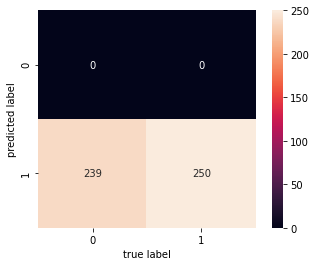

In [176]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
y_pred_sig2 = sig.predict(X_test)
mat = confusion_matrix(y_test, y_pred_sig) #Print the number of good/bad classified points 
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('true label')
plt.ylabel('predicted label');

In [177]:
print(classification_report(y_test, y_pred_sig2))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       239
           1       0.51      1.00      0.68       250

    accuracy                           0.51       489
   macro avg       0.26      0.50      0.34       489
weighted avg       0.26      0.51      0.35       489



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Comparing accuracy score to other classifier

In [178]:
from sklearn.metrics import accuracy_score
print('Accuracy score for linear kernel: {}'.format(accuracy_score(y_test, y_pred)))
print('Accuracy score for multinomial naive bayes: {}'.format(accuracy_score(y_test, y_pred_NB2)))
print('Accuracy score for KNN: {}'.format(accuracy_score(y_test, y_pred_knn2)))
print('Accuracy score for gaussian naive bayes: {}'.format(accuracy_score(y_test, y_pred_gb2)))
print('Accuracy score for sigmoid kernel: {}'.format(accuracy_score(y_test, y_pred_sig2)))

Accuracy score for linear kernel: 0.8916155419222904
Accuracy score for multinomial naive bayes: 0.8404907975460123
Accuracy score for KNN: 0.8916155419222904
Accuracy score for gaussian naive bayes: 0.8588957055214724
Accuracy score for sigmoid kernel: 0.5112474437627812
